In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import hockey.hockey_env as h_env

from rl_hockey.td3 import TD3
from rl_hockey.common import utils

# Train easy and hard bot

In [2]:
env = h_env.HockeyEnv(mode=h_env.Mode.NORMAL)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0] // 2
max_action = float(env.action_space.high.min())

In [3]:
max_episodes = 500
updates_per_step = 1
warmup_steps = 10
max_episode_steps = 500

In [4]:
new_config = {
    "critic_lr": 3e-4,
    "actor_lr": 3e-4,
    "critic_dim": 256,
    "actor_dim": 256,
    "actor_n_layers": 1,
    "critic_n_layers": 1,
    "batch_size": 256,
    "discount": 0.999,
    "action_min": float(-max_action),
    "action_max": float(max_action),
    "policy_update_delay": 2,
    "tau": 0.005,
    "noise_type": "normal",
    "exploration_noise": 0.15,
    "policy_noise": 0.1,
    "noise_clip": 0.5,
    "target_network_update_steps": 2,
    "verbose": True,
    "prioritized_replay": True,
}

In [5]:
# agent = SAC(o_space.shape[0], action_dim=ac_space.shape[0], noise='pink', max_episode_steps=max_episode_steps)
agent = TD3(state_dim, action_dim=action_dim, **new_config)

Initialized Actor:
Actor(
  (net): Sequential(
    (0): Linear(in_features=18, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=4, bias=True)
    (5): Tanh()
  )
)
Initialized Critics:
Sequential(
  (0): Linear(in_features=22, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=1, bias=True)
)


In [6]:
critic_losses = []
actor_losses = []
rewards = []
steps = 0
gradient_steps = 0
game_outcomes = []

In [7]:
strong_opponent = h_env.BasicOpponent(weak=False)

In [8]:
def evaluate_policy(agent, easy=True, num_eval_rounds=10):
    eval_env = h_env.HockeyEnv(mode=h_env.Mode.NORMAL)
    if easy:
        opponent = h_env.BasicOpponent(weak=True)
    else:
        opponent = h_env.BasicOpponent(weak=False)

    mean_reward = 0.0
    winners = []
    print("-" * 20, "Evaluation", "-" * 20)

    for _ in range(num_eval_rounds):
        (state, _), done = eval_env.reset(), False
        state2 = eval_env.obs_agent_two()
        while not done:
            action = agent.act(state, deterministic=True)
            action2 = opponent.act(np.array(state2))
            state, reward, done, trunc, info = eval_env.step(np.hstack([action, action2]))
            state2 = eval_env.obs_agent_two()
            mean_reward += reward
        
        winners.append(info["winner"])

    mean_reward /= num_eval_rounds
    winrate = winners.count(1) / num_eval_rounds
    print(f"Overall Scores, {num_eval_rounds} games:")
    print(f"Mean reward: {mean_reward:.3f}")
    print(f"Win rate: {winrate:.3f}")
    eval_env.close()

    return winrate, mean_reward

In [9]:
evaluate_policy(agent, easy=True, num_eval_rounds=10)

-------------------- Evaluation --------------------
Overall Scores, 10 games:
Mean reward: -26.323
Win rate: 0.000


(0.0, -26.322871484093213)

In [10]:
pbar = tqdm(range(max_episodes + warmup_steps), desc="TRAIN BABY TRAIN")
for i in pbar:    
    total_reward = 0
    state, info = env.reset()
    player2_state = env.obs_agent_two()
    done = False
    winrate = 0
    evaluation_mean_reward = 0

    agent.on_episode_start(i)

    for t in range(max_episode_steps):
        done = False
        if steps < warmup_steps:
            # Use Strong Opponent to generate transitions

            # Player 1 (warm up player, the one we are trying to learn from, aka the agent state)
            action = strong_opponent.act(np.array(state))

            # Player 2, uses state 2
            action2 = strong_opponent.act(np.array(player2_state))
        else:
            action = agent.act(state) # Agent's action

            # Player 2 action
            action2 = strong_opponent.act(np.array(player2_state))
        
        (next_state, reward, done, trunc, _) = env.step(np.hstack([action, action2]))
        agent.store_transition((state, action, reward, next_state, done))
        
        state = next_state
        player2_state = env.obs_agent_two()  # Update player 2 state

        steps += 1
        total_reward += reward

        if steps >= warmup_steps:  # mirroring enables 2 transitions per step
            stats = agent.train(updates_per_step)

            gradient_steps += updates_per_step
            critic_losses.extend(stats['critic_loss'])
            actor_losses.extend(stats['actor_loss'])

        if done or trunc:
            break

    agent.on_episode_end(i)

    rewards.append(total_reward)   
    if reward == 0:
        game_outcomes.append("draw")
    elif reward == 1:
        game_outcomes.append("win")
    else:
        game_outcomes.append("loss") 

    if (i + 1) % 100 == 0 and i >= warmup_steps:
        winrate, evaluation_mean_reward = evaluate_policy(agent, easy=True, num_eval_rounds=10)
    
    pbar.set_postfix({
        'total_reward': total_reward,
        'episode_length': t,
        'winrate': f"{winrate:.3f}",
        'eval_mean_reward': f"{evaluation_mean_reward:.3f}"
    })

# agent.save(f'../../../models/td3/{run_name}_{gradient_steps//1000}k.pt')

TRAIN BABY TRAIN:   0%|          | 0/510 [00:00<?, ?it/s]

TRAIN BABY TRAIN:  19%|█▉        | 99/510 [06:39<25:07,  3.67s/it, total_reward=-14.7, episode_length=61, winrate=0.000, eval_mean_reward=0.000] 

-------------------- Evaluation --------------------


TRAIN BABY TRAIN:  20%|█▉        | 100/510 [06:46<31:22,  4.59s/it, total_reward=-30.2, episode_length=250, winrate=0.000, eval_mean_reward=-18.023]

Overall Scores, 10 games:
Mean reward: -18.023
Win rate: 0.000


TRAIN BABY TRAIN:  39%|███▉      | 199/510 [14:15<30:44,  5.93s/it, total_reward=-8.19, episode_length=250, winrate=0.000, eval_mean_reward=0.000]  

-------------------- Evaluation --------------------


TRAIN BABY TRAIN:  39%|███▉      | 200/510 [14:22<32:28,  6.29s/it, total_reward=-33.8, episode_length=250, winrate=0.100, eval_mean_reward=-22.223]

Overall Scores, 10 games:
Mean reward: -22.223
Win rate: 0.100


TRAIN BABY TRAIN:  59%|█████▊    | 299/510 [22:34<15:02,  4.28s/it, total_reward=-10.9, episode_length=26, winrate=0.000, eval_mean_reward=0.000]   

-------------------- Evaluation --------------------


TRAIN BABY TRAIN:  59%|█████▉    | 300/510 [22:37<13:06,  3.75s/it, total_reward=-17.5, episode_length=65, winrate=0.000, eval_mean_reward=-24.087]

Overall Scores, 10 games:
Mean reward: -24.087
Win rate: 0.000


TRAIN BABY TRAIN:  78%|███████▊  | 399/510 [33:36<11:13,  6.07s/it, total_reward=8.45, episode_length=69, winrate=0.000, eval_mean_reward=0.000]   

-------------------- Evaluation --------------------


TRAIN BABY TRAIN:  78%|███████▊  | 400/510 [33:48<14:24,  7.86s/it, total_reward=-52.5, episode_length=250, winrate=0.000, eval_mean_reward=-27.652]

Overall Scores, 10 games:
Mean reward: -27.652
Win rate: 0.000


TRAIN BABY TRAIN:  85%|████████▌ | 436/510 [39:09<06:38,  5.39s/it, total_reward=-42, episode_length=250, winrate=0.000, eval_mean_reward=0.000]    


KeyboardInterrupt: 

In [12]:
def moving_average(data, window_size):
    moving_averages = []
    for i in range(len(data)):
        window_start = max(0, i - window_size + 1)
        window = data[window_start:i + 1]
        moving_averages.append(sum(window) / len(window))
    
    return moving_averages

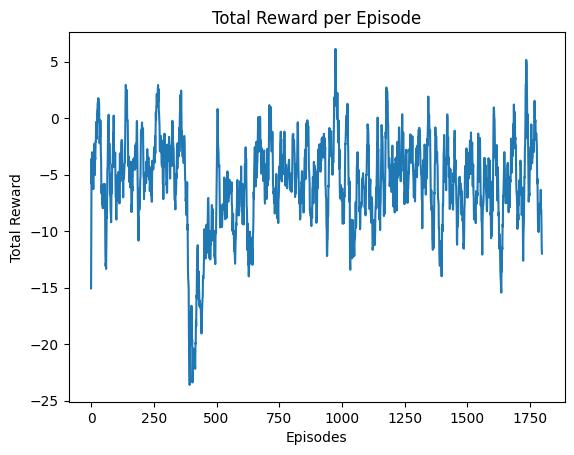

In [13]:
plt.plot(moving_average(rewards, 10))
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()

In [14]:
np.max(rewards)

np.float64(9.981851898769605)

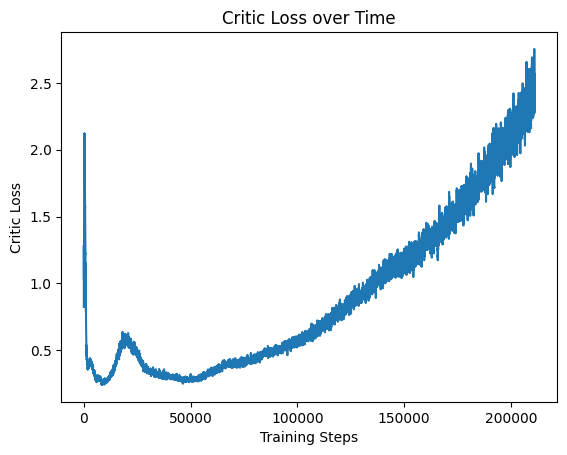

In [15]:
plt.plot(moving_average(critic_losses, 100))
plt.xlabel('Training Steps')
plt.ylabel('Critic Loss')
plt.title('Critic Loss over Time')
plt.show()

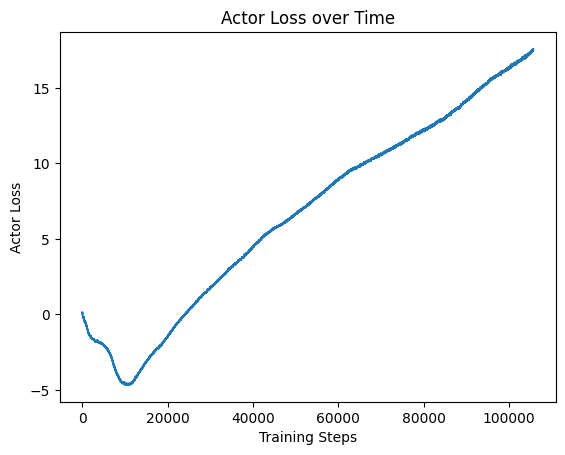

In [16]:
plt.plot(moving_average(actor_losses, 100))
plt.xlabel('Training Steps')
plt.ylabel('Actor Loss')
plt.title('Actor Loss over Time')
plt.show()

In [ ]:
def evaluate_policy(agent, env_mode = "TRAIN_SHOOTING", num_eval_rounds=10):
    if env_mode == "TRAIN_SHOOTING":
        mode = h_env.Mode.TRAIN_SHOOTING
    else:
        mode = h_env.Mode.TRAIN_DEFENSE
    
    eval_env = h_env.HockeyEnv(mode=mode)

    mean_reward = 0.0

    for _ in range(num_eval_rounds):
        (state, _), done = eval_env.reset(), False
        while not done:
            action = agent.act(state, deterministic=True)
            state, reward, done, trunc, _ = eval_env.step(action)
            mean_reward += reward

    mean_reward /= num_eval_rounds

    print(f"Evaluation {num_eval_rounds} episodes: {mean_reward:.3f}")
    eval_env.close()
    return mean_reward

In [ ]:
evaluate_policy(agent, num_eval_rounds=100)

Evaluation 100 episodes: 5.947


5.947087866128124